In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr  9 22:45:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/yhacks

dataset  output.avi  train.txt	weights_0.params  weights_9.params


In [ ]:
!nvcc --version 
!pip install -U mxnet-cu101==1.7.0    
#version was 1.7.0
!pip install --upgrade gluoncv
!pip install decord

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
     |███████████████████████████████▌| 834.1 MB 1.4 MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x563341942000 @  0x7fa47c5c7615 0x563307c2217c 0x563307d0247a 0x563307c24f9d 0x563307d16d4d 0x563307c98ec8 0x563307c93a2e 0x563307c2688a 0x563307c98d30 0x563307c93a2e 0x563307c2688a 0x563307c95719 0x563307d17b76 0x563307c94d95 0x563307d17b76 0x563307c94d95 0x563307d17b76 0x563307c94d95 0x563307c26ce9 0x563307c6a579 0x563307c25902 0x563307c98c4d 0x563307c93a2e 0x563307c2688a 0x563307c95719 0x563307c93a2e 0x563307c2688a 0x563307c948f6 0x563307c267aa 0x563307c94b4f 0x563307c93a2e
     |████████████████████████████████| 846.0 MB 22 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalle

In [ ]:

from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np

import pandas
from decord import VideoReader

import mxnet as mx
import gluoncv 
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
import gluoncv.data 
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


TRAIN DATA GENRATOR


In [ ]:
#https://medium.com/apache-mxnet/gluoncv-0-6-embrace-video-understanding-49bc10ec1421

num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.9]), #WAS THIS  scale_ratios=[1.0, 0.875, 0.75, 0.66]
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    #video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

per_device_batch_size = 2 #change batch size over here 
num_workers = 0 # these two lines are used if we were trying to use multiple gpus - so ignore
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser('/content/drive/MyDrive/yhacks/'),#bounded_videos/'),
                               setting=os.path.expanduser('/content/drive/MyDrive/yhacks/train.txt'),  #CHANGE
                               train=True,
                               video_loader=True,
                               use_decord=True,
                               #video_ext = 'mp4',
                               new_length=80,
                              #  slowfast=True,
                              #  slow_temporal_stride=8,
                              #  fast_temporal_stride=2,
                              #  new_height = 224,
                              # new_width= 224,
                               transform=transform_train
                               )
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)


Load 10 training samples.


VAL DATA GENERATOR


In [ ]:
# #https://medium.com/apache-mxnet/gluoncv-0-6-embrace-video-understanding-49bc10ec1421

num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.9]), #WAS THIS  scale_ratios=[1.0, 0.875, 0.75, 0.66]
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
   # video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

per_device_batch_size =16 #change batch size over here 
num_workers = 0 # these two lines are used if we were trying to use multiple gpus - so ignore
batch_size = per_device_batch_size * num_gpus

val_dataset = VideoClsCustom(root=os.path.expanduser('/content/drive/MyDrive/yhacks/'),#bounded_videos/'),
                               setting=os.path.expanduser('/content/drive/MyDrive/yhacks/train.txt'),  #CHANGE
                               train=False,
                               video_loader=True,
                               use_decord=True,
                               #video_ext = 'mp4',
                               new_length=80,
                              #  slowfast=True,
                              #  slow_temporal_stride=8,
                              #  fast_temporal_stride=2,
                              #  new_height = 224,
                              # new_width= 224,
                               transform=transform_train
                               )


print('Load %d training samples.' % len(val_dataset))
val_data = gluon.data.DataLoader(val_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)


Load 10 training samples.



will get erroe if you set pretrained = true. Instead you should set pretrained_base = true as we are changing the number of classes 

In [ ]:
# url = f"https://raw.githubusercontent.com/dmlc/gluon-cv/6818c3270454e8262dff3088d2c5a9ad742294d3/gluoncv/model_zoo/action_recognition/slowfast.py"
# !wget --no-cache --backups=1 {url} 


In [ ]:

# import slowfast

In [ ]:
#net = gluoncv.model_zoo.slowfast_4x16_resnet50_kinetics400(nclass=50, pretrained_base=True, num_segments=1, ctx=ctx)#check num_segments
#net = get_model(name='i3d_resnet50_v1_custom', nclass=2)
#kinetics_model = get_model(name='slowfast_8x8_resnet101_kinetics400', nclass=400, pretrained=True)
net = get_model(name='i3d_resnet50_v1_custom',nclass=2,pretrained=False,pretrained_base=True,feat_ext=False,partial_bn=True)

                   
                     
                    

# source_params = kinetics_model.collect_params()
# target_params = net.collect_params()
# assert len(source_params.keys()) == len(target_params.keys())

# pretrained_weights=[]
# for layer_name in source_params.keys():
#     pretrained_weights.append(source_params[layer_name].data())

# for i, layer_name in enumerate(target_params.keys()):
#     if i + 2 == len(source_params.keys()):
#         # skip the last dense layer
#         break
#     target_params[layer_name].set_data(pretrained_weights[i])

# net.collect_params().reset_ctx(ctx)

100%|██████████| 55344/55344 [00:01<00:00, 37602.33KB/s]


conv0_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm0_gamma is done with shape:  (64,)
batchnorm0_beta is done with shape:  (64,)
batchnorm0_running_mean is done with shape:  (64,)
batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

100%|██████████| 208483/208483 [00:11<00:00, 18177.46KB/s]


In [ ]:
# net.summary
# or print(net) , both work 

In [ ]:
# mx.viz.plot_network(net(mx.sym.var('data'))[0], node_attrs={"shape":"oval","fixedsize":"false"},hide_weights=False,save_format='pdf').render()

In [ ]:

net.collect_params().reset_ctx(ctx)
net.collect_params().reset_ctx(mx.Context('cpu'))
net.load_parameters('/content/drive/MyDrive/yhacks/weights_9.params')
net.collect_params().reset_ctx(mx.Context('gpu'))

In [ ]:
net.collect_params().setattr('grad_req', 'null')


# net.res_layers[3].collect_params().setattr('grad_req', 'write')
# net.res_layers[2].collect_params().setattr('grad_req', 'write')
# net.st_avg.collect_params().setattr('grad_req', 'write')
net.head.collect_params().setattr('grad_req', 'write')
net.fc.collect_params().setattr('grad_req', 'write')
net.collect_params().reset_ctx(mx.Context('gpu'))

In [ ]:
net.hybridize()
warmup_epoch = 2
total_epoch = 10
num_batches = len(train_data)

scheduler=mx.lr_scheduler.CosineScheduler(max_update=total_epoch, base_lr=1e-4, final_lr=1e-6, warmup_steps=warmup_epoch,  warmup_mode='constant',warmup_begin_lr=1e-4)

# lr_scheduler = LRSequential([
#     LRScheduler('linear', base_lr=0.1, target_lr=0.12,
#                 nepochs=warmup_epoch, iters_per_epoch=num_batches),
#     LRScheduler('cosine', base_lr=0.12, target_lr=0,
#                 nepochs=total_epoch - warmup_epoch,
#                 iters_per_epoch=num_batches,
#                 step_factor=lr_decay, power=2)
# ])
# Stochastic gradient descent
optimizer = 'Adam'#mxnet.optimizer.Adam(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, )
# Set parameters
#optimizer_params = {'learning_rate':  0.005}  #,'wd': 0.0001, 'momentum': 0.9}
#optimizer_params['lr_scheduler'] = lr_scheduler
optimizer_params = {'wd': 1e-4}  #,'wd': 0.0001,




# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)#the set of parameters to optimize
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
train_metric = mx.metric.Accuracy()
val_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc']) 

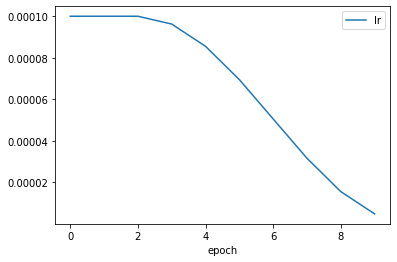

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['epoch','lr'])
for i in range(total_epoch):
  dictionary = {'epoch':i,'lr':scheduler(i)}
  df = df.append(dictionary,ignore_index=True)
  #print(optimizer.learning_rate)
df.plot(x = 'epoch', y = 'lr')


valid_acc = metric.Accuracy()
for data,label in valid_data:
    output = network(data)
    valid_acc.update(label,output)

[Epoch 0] train=0.900000 loss=0.676221 lr=0.000100 time: 6.306873
[Epoch 1] train=0.800000 loss=0.683104 lr=0.000100 time: 6.329958
[Epoch 2] train=1.000000 loss=0.662342 lr=0.000100 time: 6.686812
[Epoch 3] train=0.900000 loss=0.670496 lr=0.000096 time: 6.061710
[Epoch 4] train=1.000000 loss=0.651996 lr=0.000086 time: 5.734033
[Epoch 5] train=0.700000 loss=0.657466 lr=0.000069 time: 6.006545
[Epoch 6] train=0.900000 loss=0.658228 lr=0.000051 time: 7.413042
[Epoch 7] train=0.800000 loss=0.676052 lr=0.000032 time: 5.969315
[Epoch 8] train=0.800000 loss=0.672363 lr=0.000015 time: 5.896529
[Epoch 9] train=0.900000 loss=0.663253 lr=0.000005 time: 5.910499


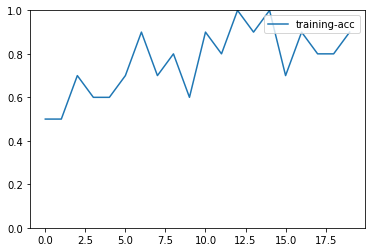

In [ ]:
epochs = total_epoch

for epoch in range(epochs):
    lr = scheduler(epoch)
    trainer.set_learning_rate(lr)
    tic = time.time()
    train_metric.reset()
    val_metric.reset()
    train_loss = 0

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        #if i == 100:
         #   break

    name, acc = train_metric.get()

    #--------------------------------------------------------------------------
    # for i, batch in enumerate(val_data):
    #     # Extract data and label
    #     data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
    #     label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        
    #     val_output = []
    #     for _, X in enumerate(data):
    #         X = X.reshape((-1,) + X.shape[2:])
    #         pred = net(X)
    #         val_output.append(pred)
            
   
    #     val_metric.update(label, val_output)
    # name_val, val_acc = val_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    # print('[Epoch %d] train=%f val=%f loss=%f lr=%f time: %f' %
    #     (epoch, acc, val_acc, train_loss / (i+1),trainer.learning_rate, time.time()-tic))
    print('[Epoch %d] train=%f loss=%f lr=%f time: %f' %
        (epoch, acc, train_loss / (i+1),trainer.learning_rate, time.time()-tic))
    
    if epoch%9==0:
      x = epoch 
      file_name = '/content/drive/MyDrive/yhacks/weights_'+str(x)+'.params'
      net.save_parameters(file_name)
# We can plot the metric scores with:
train_history.plot()


In [ ]:
# print(net.slow_res3[0].conv1.weight.data())
# print(net.fc.weight.data())

In [ ]:
import os
import pandas as pd
import random
import shutil

class_str = []
class_str_dict = {}
for word in os.listdir('/content/drive/MyDrive/yhacks/dataset'):   #CHANGE
    class_str.append(word)
for work in class_str:
  seperate = work.split('_')
  # print(seperate)
  num = int(seperate[1])
  c = str(seperate[0])
  class_str_dict[num] =  c
  class_str = []
# print(class_str_dict)
for i in range(len(class_str_dict)):
    class_str.append(class_str_dict[i])




from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math as m
import matplotlib.pyplot as plt
k = []
for i in range(2):
  k.append(i)
val_metric = mx.metric.Accuracy()
# val2 = mx.metric.TopKAccuracy(top_k = 3)
# val3 = mx.metric.TopKAccuracy(top_k = 5)
# val3.reset()
# val2.reset()
val_metric.reset()
y_true = []
predictions_valid = []
y_pred = []
# print(len(val_dataset))
for i, batch in enumerate(val_data): # here change accordingly whether val or train
        
        # print(i)
        # print(len(val_data))
        # if i==m.ceil(len(val_dataset)/16): # declare these 2 variables and also change according with val and train
        #   break
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        y_true = y_true + label[0].asnumpy().tolist()
        val_output = []
        for _, X in enumerate(data):
            X = X.reshape((-1,) + X.shape[2:])
            # print(X.shape)
            # print(type(X))
            pred = net(X)
            # print(pred.shape)
            val_output.append(pred)
            predictions_valid  = predictions_valid + pred.asnumpy().tolist()
        val_metric.update(label, val_output)
        # val2.update(label, val_output)
        # val3.update(label, val_output)

name_val, val_acc = val_metric.get()
# print('val=%f'  %(val_acc))
# print(val2)
# print(val3)
 
for i in range(0,len(predictions_valid)):
    y_pred = y_pred + [np.argmax(predictions_valid[i])]

# print(len(y_pred))
# print(len(y_true))
# print(y_true)
# print(y_pred)
for i in y_pred:
  if i==0:
    print("Child is flapping arms and suffering from Autism")
  else:
    print("Child is banging or shaking head continuously and suffering from Autism")

score = accuracy_score(y_true, y_pred)
# print('Classification Report: ',classification_report(y_true,y_pred))
cm = confusion_matrix(y_true, y_pred)
# f,ax= plt.subplots(figsize=(15, 15))
# sns.heatmap(cm,annot = True, fmt='g', ax=ax,) #annot=True to annotate cells, ftm='g' to disable scientific notation

#labels, title and ticks
#ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
#ax.set_title('Confusion Matrix');
classes_rev = []

classes = k
l = 2
for i in range(1,l+1):
    classes_rev = classes_rev + [classes[l-i]]
# ax.xaxis.set_ticklabels(class_str);ax.yaxis.set_ticklabels(class_str);
# plt.yticks(rotation='horizontal')
# plt.xticks(rotation=90)
# ax.xaxis.set_ticklabels(classes);ax.yaxis.set_ticklabels(classes);
# ax.figure.savefig("confusion_mat_of_i3dres50_1.png",dpi=500)        #CHANGE FILE NAME 
# print('Accuracy: ', score)
# print('F1',sklearn.metrics.f1_score(y_true, y_pred, average='weighted'))

with open('i3dres50_FINAL.txt','w') as ft:       #CHANGE FILEN NAME
  for r in cm:
   for c in r:
      ft.write(str(c))
   ft.write('\n')
  

Child is banging or shaking head continuously and suffering from Autism
Child is banging or shaking head continuously and suffering from Autism
Child is flapping arms and suffering from Autism
Child is banging or shaking head continuously and suffering from Autism
Child is banging or shaking head continuously and suffering from Autism
Child is flapping arms and suffering from Autism
Child is flapping arms and suffering from Autism
Child is banging or shaking head continuously and suffering from Autism
Child is flapping arms and suffering from Autism
Child is flapping arms and suffering from Autism


In [ ]:
mx.nd.array(numpy_ex_int_array)

In [ ]:
X = X.reshape((-1,) + X.shape[2:])
print(X.shape)
print(type(X))
pred = net(X)

In [ ]:
!pip install sk-video

     |████████████████████████████████| 2.3 MB 10.3 MB/s 


In [ ]:
import skvideo.io  
videodata = skvideo.io.vread("drive/MyDrive/yhacks/dataset/armflapping_0/afn2.mp4")  
print(videodata.shape)
x = mx.nd.array(videodata)
type(x)

(122, 360, 480, 3)


mxnet.ndarray.ndarray.NDArray